<a href="https://colab.research.google.com/github/meghana2343/ADS-Project/blob/main/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

Saving finaldataset.csv to finaldataset (2).csv


<Axes: >

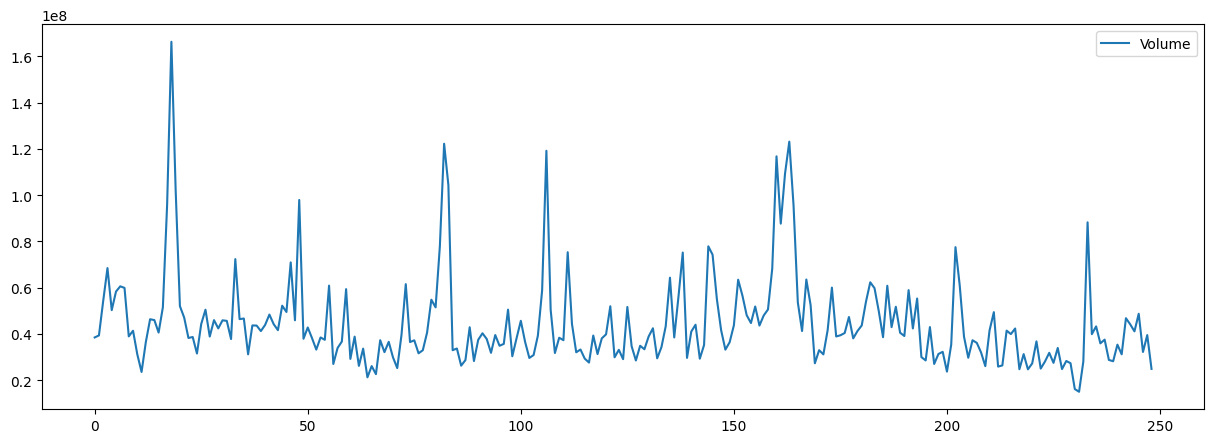

In [ ]:
dataset = pd.read_csv("finaldataset.csv")
dataset.head(5)
dataset.plot(figsize=(15, 5))
plt.savefig('plot.png')

In [ ]:
dataset.shape


(249, 6)

In [ ]:
#preprocessing data


In [ ]:
dataset.isna().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        249 non-null    object
 1   Close/Last  249 non-null    object
 2   Volume      249 non-null    int64 
 3   Open        249 non-null    object
 4   High        249 non-null    object
 5   Low         249 non-null    object
dtypes: int64(1), object(5)
memory usage: 11.8+ KB


In [ ]:
#converting the 'Date' column into 'datetime' dtype
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [ ]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        249 non-null    datetime64[ns]
 1   Close/Last  249 non-null    object        
 2   Volume      249 non-null    int64         
 3   Open        249 non-null    object        
 4   High        249 non-null    object        
 5   Low         249 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 11.8+ KB


In [ ]:
#making the 'Date ' col as index
dataset.set_index('Date',inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2025-11-26 to 2024-11-29
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  249 non-null    object
 1   Volume      249 non-null    int64 
 2   Open        249 non-null    object
 3   High        249 non-null    object
 4   Low         249 non-null    object
dtypes: int64(1), object(4)
memory usage: 11.7+ KB


In [ ]:
dataset.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2025-11-26,$229.16,38497920,$230.74,$231.7474,$228.77
2025-11-25,$229.67,39379340,$226.38,$230.52,$223.80
2025-11-24,$226.28,54318400,$222.555,$227.33,$222.27
2025-11-21,$220.69,68490460,$216.345,$222.21,$215.18
2025-11-20,$217.14,50308960,$227.05,$227.41,$216.74


In [ ]:
#sorting the indexes
dataset.sort_index(inplace=True)

In [ ]:
# Remove $ and convert selected columns to numeric
cols = ['Close/Last', 'Open', 'High', 'Low']
for col in cols:
    dataset[col] = dataset[col].replace({r'\$': ''}, regex=True).astype(float)

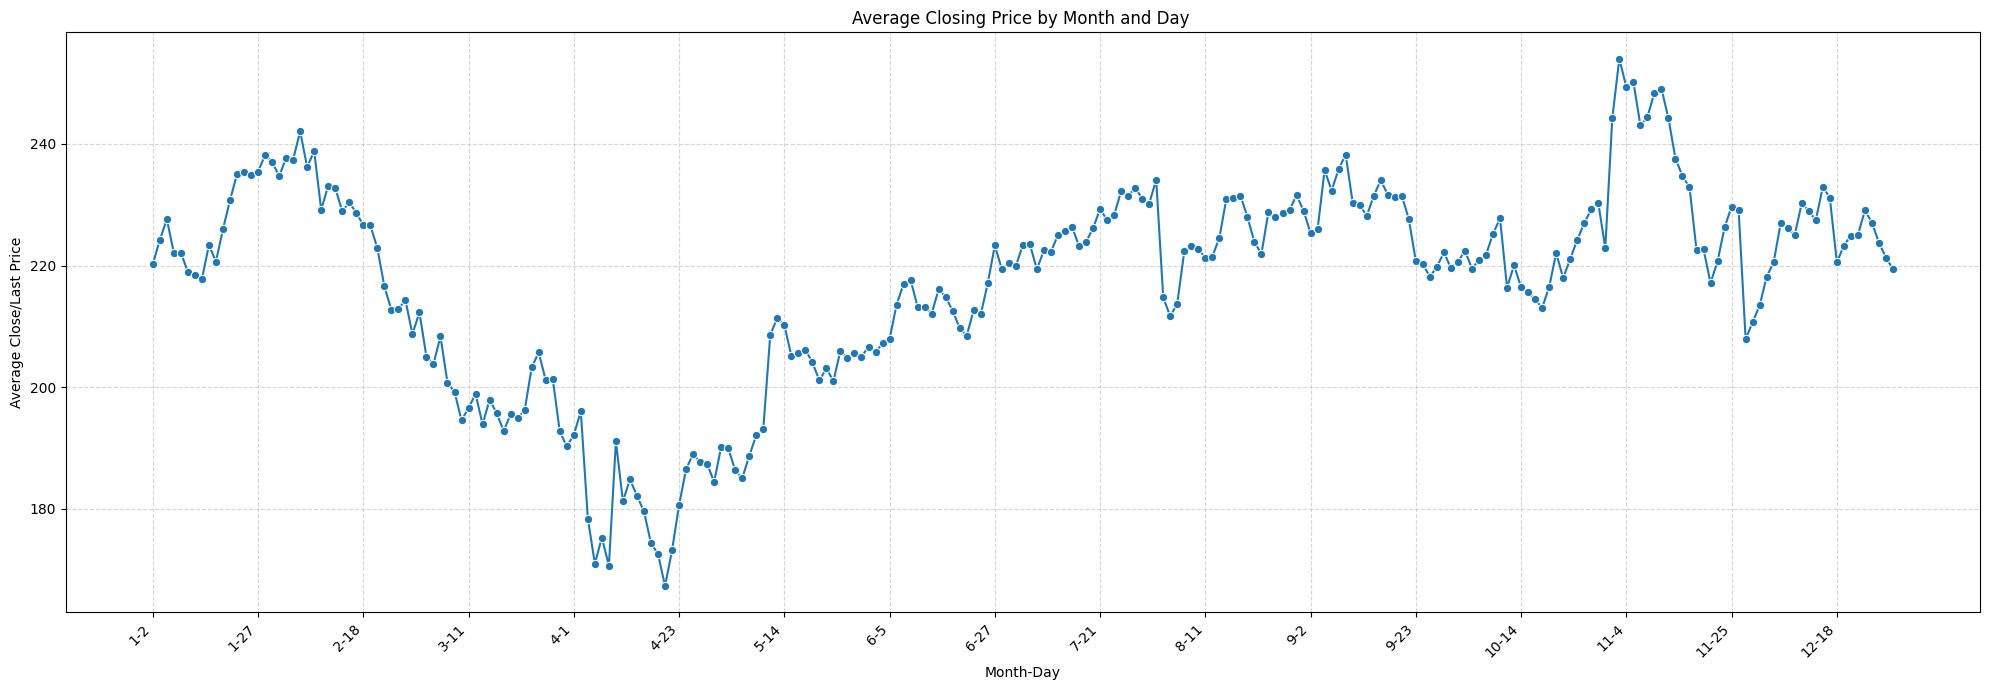

In [ ]:
# Create 'Month' and 'Day' columns from the Date index
dataset['Month'] = dataset.index.month
dataset['Day'] = dataset.index.day

# Convert 'Close/Last' to numeric after removing '$' - This was already done in a previous cell (UMl_-qTRPN1t)
# dataset['Close/Last'] = dataset['Close/Last'].replace({r'\$': ''}, regex=True).astype(float)

# Group by Month and Day and calculate the mean of 'Close/Last'
daily_avg_price = dataset.groupby(['Month', 'Day'])['Close/Last'].mean().reset_index()

# Create a combined 'Month-Day' string for plotting
daily_avg_price['Month_Day'] = daily_avg_price['Month'].astype(str) + '-' + daily_avg_price['Day'].astype(str)

# Plotting the average 'Close/Last' price by month and day
plt.figure(figsize=(20, 7))
sns.lineplot(x='Month_Day', y='Close/Last', data=daily_avg_price, marker='o')
plt.title('Average Closing Price by Month and Day ')
plt.xlabel('Month-Day')
plt.ylabel('Average Close/Last Price')

# Correcting the x-axis labels for better readability
step = 15 # Display every 15th label
num_labels = len(daily_avg_price['Month_Day'])
selected_indices = np.arange(0, num_labels, step)
selected_labels = daily_avg_price['Month_Day'].iloc[selected_indices]

plt.xticks(selected_indices, selected_labels, rotation=45, ha='right', fontsize=10) # Rotate labels, increase fontsize
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-11-29 to 2025-11-26
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  249 non-null    float64
 1   Volume      249 non-null    int64  
 2   Open        249 non-null    float64
 3   High        249 non-null    float64
 4   Low         249 non-null    float64
 5   Month       249 non-null    int32  
 6   Day         249 non-null    int32  
dtypes: float64(4), int32(2), int64(1)
memory usage: 13.6 KB


In [ ]:
#data normalization
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_cols = dataset.select_dtypes(include=np.number).columns

if not numeric_cols.empty:
    scaler_values = scaler.fit_transform(dataset[numeric_cols])
    # Assign scaled values back to the numeric columns of the original dataset
    dataset[numeric_cols] = scaler_values
else:
    print("No numeric columns found to scale.")

In [ ]:
scaler_values

array([[0.46804338, 0.06531907, 0.46947301, ..., 0.47213724, 0.90909091,
        0.93333333],
       [0.50057683, 0.16199799, 0.51371037, ..., 0.52589707, 1.        ,
        0.03333333],
       [0.53207199, 0.11370485, 0.5174593 , ..., 0.5274257 , 1.        ,
        0.06666667],
       ...,
       [0.68020305, 0.25976371, 0.64861825, ..., 0.66531906, 0.90909091,
        0.76666667],
       [0.71931241, 0.16104744, 0.68958869, ..., 0.68203671, 0.90909091,
        0.8       ],
       [0.7134287 , 0.15522307, 0.73628963, ..., 0.73634178, 0.90909091,
        0.83333333]])

In [ ]:
dataset_scaled=pd.DataFrame(scaler_values,columns=dataset.columns, index=dataset.index)

In [ ]:
# Display dataset_scaled.head() with index formatted as MM-DD
print("Dataset Scaled Head with Month-Day Index:")
df_display = dataset_scaled.copy()
df_display.index = df_display.index.strftime('%m-%d')
print(df_display.head())

Dataset Scaled Head with Month-Day Index:
       Close/Last    Volume      Open      High       Low     Month       Day
Date                                                                         
11-29    0.468043  0.065319  0.469473  0.433708  0.472137  0.909091  0.933333
12-02    0.500577  0.161998  0.513710  0.487528  0.525897  1.000000  0.033333
12-03    0.532072  0.113705  0.517459  0.499101  0.527426  1.000000  0.066667
12-04    0.586525  0.222940  0.577978  0.566292  0.594078  1.000000  0.100000
12-05    0.614098  0.172683  0.600150  0.590449  0.611014  1.000000  0.133333


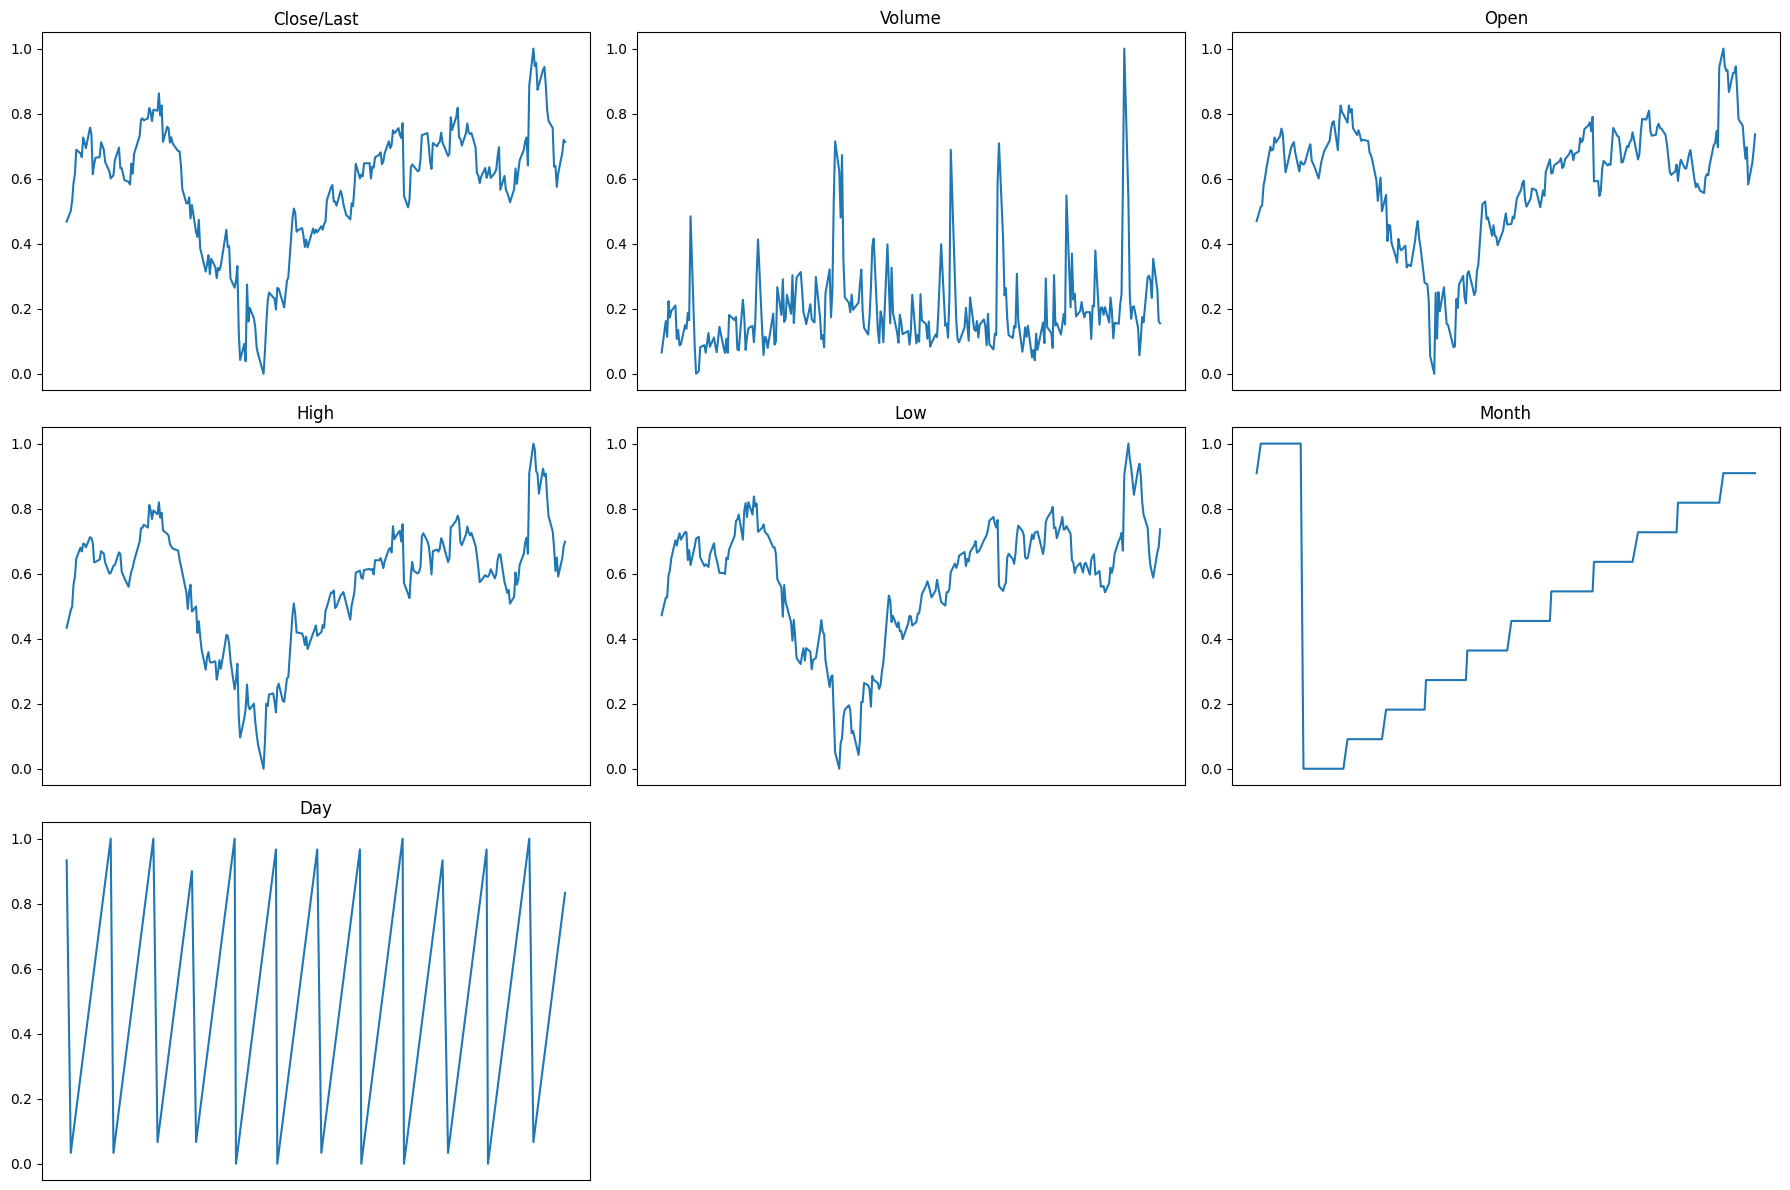

In [ ]:
#plotting columns with better spacing
figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12)) # Create a 3x3 grid for 7 columns
ax = ax.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(dataset_scaled.columns):
    ax[i].plot(dataset_scaled[col])
    ax[i].set_title(col)
    ax[i].axes.get_xaxis().set_visible(False)

# Hide any unused subplots
for j in range(len(dataset_scaled.columns), len(ax)):
    figure.delaxes(ax[j])

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
## creating the sliding window sequence

def create_sequences(data,window_size):
    x = []
    y = []
    for i in range(window_size, len(data)):
        x.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(x),np.array(y)

In [ ]:
window_size=34
x, y = create_sequences(dataset_scaled, 20)

In [ ]:
x.shape, y.shape

((229, 20, 7), (229, 7))

In [ ]:
x

array([[[0.46804338, 0.06531907, 0.46947301, ..., 0.47213724,
         0.90909091, 0.93333333],
        [0.50057683, 0.16199799, 0.51371037, ..., 0.52589707,
         1.        , 0.03333333],
        [0.53207199, 0.11370485, 0.5174593 , ..., 0.5274257 ,
         1.        , 0.06666667],
        ...,
        [0.71215967, 0.        , 0.69558698, ..., 0.70749563,
         1.        , 0.76666667],
        [0.68908629, 0.00771146, 0.71229649, ..., 0.71340253,
         1.        , 0.83333333],
        [0.65101523, 0.08167171, 0.68123393, ..., 0.65034965,
         1.        , 0.86666667]],

       [[0.50057683, 0.16199799, 0.51371037, ..., 0.52589707,
         1.        , 0.03333333],
        [0.53207199, 0.11370485, 0.5174593 , ..., 0.5274257 ,
         1.        , 0.06666667],
        [0.58652515, 0.22293983, 0.57797772, ..., 0.5940778 ,
         1.        , 0.1       ],
        ...,
        [0.68908629, 0.00771146, 0.71229649, ..., 0.71340253,
         1.        , 0.83333333],
        [0.6

In [ ]:
y

array([[0.62275035, 0.08797627, 0.62189374, ..., 0.62336101, 1.        ,
        0.96666667],
       [0.60071527, 0.06483808, 0.65300985, ..., 0.62893357, 1.        ,
        1.        ],
       [0.61029072, 0.12521421, 0.64299486, ..., 0.62073864, 0.        ,
        0.03333333],
       ...,
       [0.68020305, 0.25976371, 0.64861825, ..., 0.66531906, 0.90909091,
        0.76666667],
       [0.71931241, 0.16104744, 0.68958869, ..., 0.68203671, 0.90909091,
        0.8       ],
       [0.7134287 , 0.15522307, 0.73628963, ..., 0.73634178, 0.90909091,
        0.83333333]])

In [ ]:
#train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=24)
x_train.shape, x_test.shape,


((171, 20, 7), (58, 20, 7))

In [ ]:
x_train.shape[1], x_train.shape[1]

(20, 20)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - RootMeanSquaredError: 0.3401 - loss: 0.1241 - val_RootMeanSquaredError: 0.1531 - val_loss: 0.0234
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1952 - loss: 0.0382 - val_RootMeanSquaredError: 0.1457 - val_loss: 0.0212
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1676 - loss: 0.0283 - val_RootMeanSquaredError: 0.1349 - val_loss: 0.0182
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1484 - loss: 0.0222 - val_RootMeanSquaredError: 0.1378 - val_loss: 0.0190
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1526 - loss: 0.0235 - val_RootMeanSquaredError: 0.1242 - val_loss: 0.0154
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1334 - loss: 0.0178 - val_RootMeanSquaredError: 0.1179 - val_loss: 0.0139
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - RootMeanSquaredError: 0.1229 - loss: 0.0152 - val_Roo

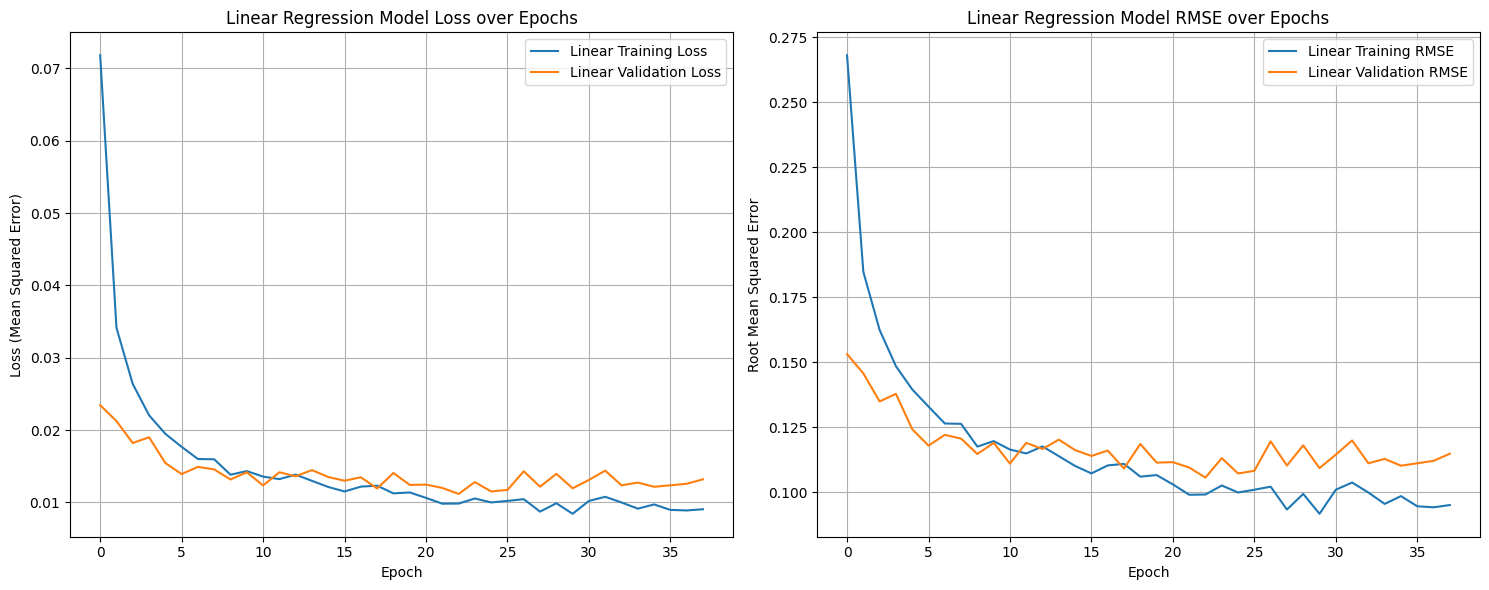

In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

model_linear = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])

model_linear.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

early_stopping_linear = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_linear = model_linear.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.25, callbacks=[early_stopping_linear])

# Evaluate Linear Regression model
linear_evaluation = model_linear.evaluate(x_test, y_test, verbose=0)
linear_rmse = linear_evaluation[1]
print(f"Linear Regression Model RMSE: {linear_rmse:.4f}")

# Plotting training history for Linear Regression model
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history_linear.history['loss'], label='Linear Training Loss')
plt.plot(history_linear.history['val_loss'], label='Linear Validation Loss')
plt.title('Linear Regression Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_linear.history['RootMeanSquaredError'], label='Linear Training RMSE')
plt.plot(history_linear.history['val_RootMeanSquaredError'], label='Linear Validation RMSE')
plt.title('Linear Regression Model RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## lstm models
model= keras.Sequential([
    #adding firsr  lstm layers
    keras.layers.LSTM(units=52, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    keras.layers.Dropout(0.3),
    #adding second lstm layers
    keras.layers.LSTM(units=52, return_sequences=True),
    keras.layers.Dropout(0.3),
    #adding third lstm layers
    keras.layers.LSTM(units=52, return_sequences=False),
    keras.layers.Dropout(0.3),
    #adding output layers
    keras.layers.Dense(y_train.shape[1])



])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

In [ ]:
#early stopping condition
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)


In [ ]:
prediction = model.fit(x_train, y_train, epochs=100, batch_size=3, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - RootMeanSquaredError: 0.3817 - loss: 0.1513 - val_RootMeanSquaredError: 0.1828 - val_loss: 0.0334
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.2259 - loss: 0.0511 - val_RootMeanSquaredError: 0.1715 - val_loss: 0.0294
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.2036 - loss: 0.0415 - val_RootMeanSquaredError: 0.1643 - val_loss: 0.0270
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.2213 - loss: 0.0491 - val_RootMeanSquaredError: 0.1606 - val_loss: 0.0258
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RootMeanSquaredError: 0.1996 - loss: 0.0399 - val_RootMeanSquaredError: 0.1641 - val_loss: 0.0269
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.1889 - loss: 0.0357 - val_RootMeanSquaredError: 0.1624 - val_loss: 0.0264
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.1901 - los

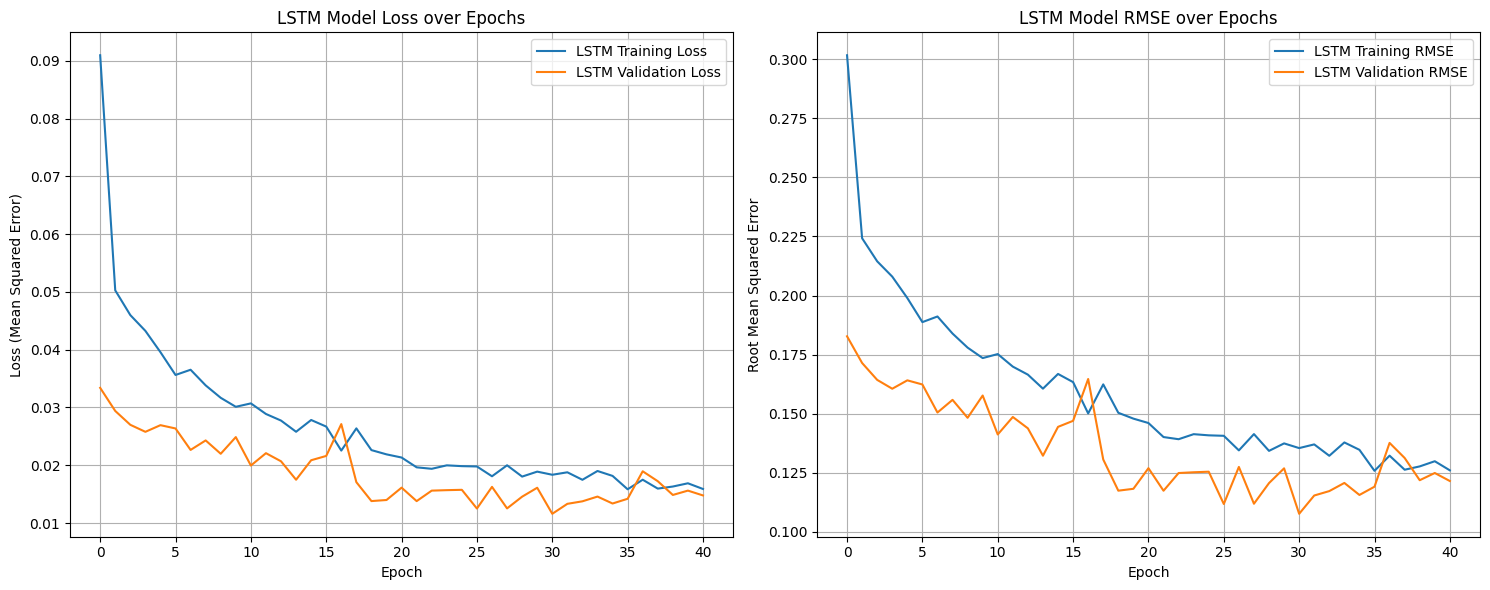

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - RootMeanSquaredError: 0.3189 - loss: 0.1097 - val_RootMeanSquaredError: 0.1671 - val_loss: 0.0279
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - RootMeanSquaredError: 0.2110 - loss: 0.0448 - val_RootMeanSquaredError: 0.1688 - val_loss: 0.0285
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - RootMeanSquaredError: 0.1919 - loss: 0.0370 - val_RootMeanSquaredError: 0.1501 - val_loss: 0.0225
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - RootMeanSquaredError: 0.1820 - loss: 0.0332 - val_RootMeanSquaredError: 0.1479 - val_loss: 0.0219
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - RootMeanSquaredError: 0.1870 - loss: 0.0350 - val_RootMeanSquaredError: 0.1366 - val_loss: 0.0187
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - RootMeanSquaredError: 0.1595 - loss: 0.0255 - val_RootMeanSquaredError: 0.1370 - val_loss: 0.0188
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - RootMeanSquaredError: 0.1510 - loss: 0.0229 -

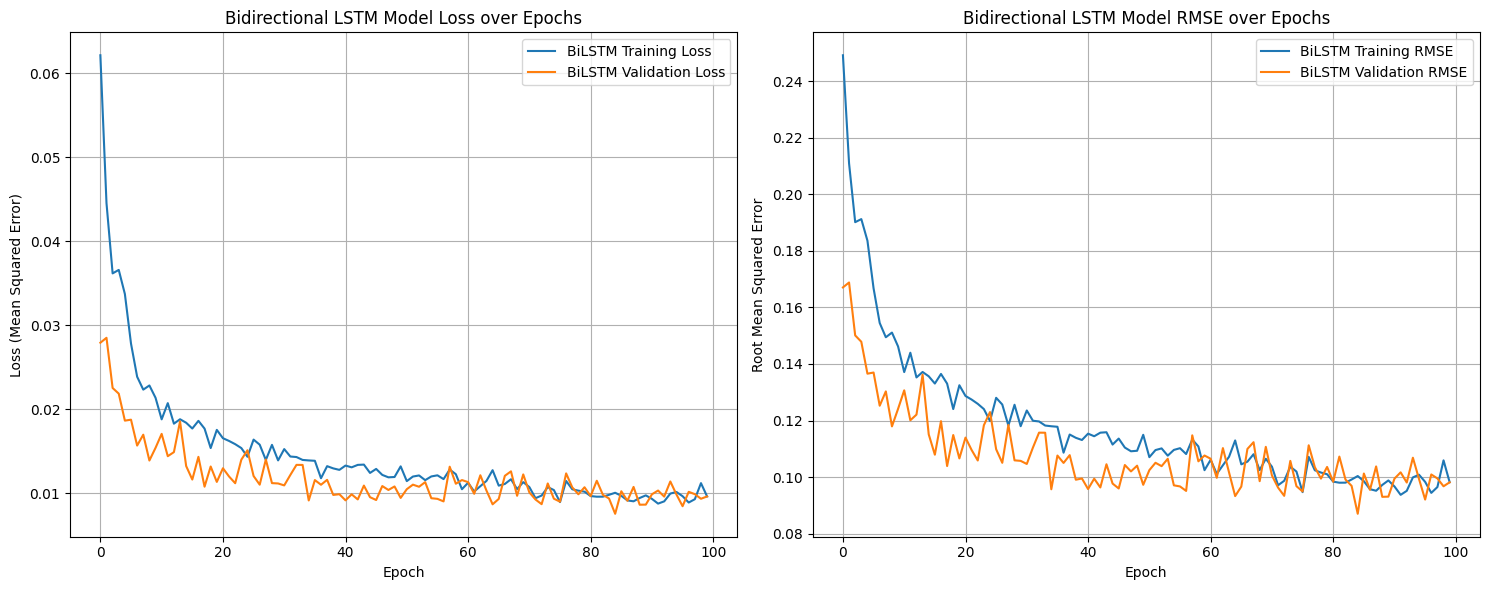

In [ ]:
import matplotlib.pyplot as plt

# Plotting training history for LSTM model
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(prediction.history['loss'], label='LSTM Training Loss')
plt.plot(prediction.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(prediction.history['RootMeanSquaredError'], label='LSTM Training RMSE')
plt.plot(prediction.history['val_RootMeanSquaredError'], label='LSTM Validation RMSE')
plt.title('LSTM Model RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#bilstm model
model_bilstm = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    Dense(y_train.shape[1])
])

model_bilstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])
early_stopping_bilstm = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history_bilstm = model_bilstm.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.25, callbacks=[early_stopping_bilstm])

# Plotting training history for Bidirectional LSTM model
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='BiLSTM Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Validation Loss')
plt.title('Bidirectional LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['RootMeanSquaredError'], label='BiLSTM Training RMSE')
plt.plot(history_bilstm.history['val_RootMeanSquaredError'], label='BiLSTM Validation RMSE')
plt.title('Bidirectional LSTM Model RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
predictions=model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
prediction.history

{'RootMeanSquaredError': [0.30162033438682556,
  0.22422975301742554,
  0.21446748077869415,
  0.20799745619297028,
  0.19893980026245117,
  0.1887563318014145,
  0.19113858044147491,
  0.1839197874069214,
  0.17797055840492249,
  0.1735493540763855,
  0.17524167895317078,
  0.16993466019630432,
  0.16654005646705627,
  0.16061538457870483,
  0.16683745384216309,
  0.16338108479976654,
  0.1501336246728897,
  0.16242581605911255,
  0.15040558576583862,
  0.14793874323368073,
  0.14607787132263184,
  0.14014624059200287,
  0.13923171162605286,
  0.14136388897895813,
  0.14087314903736115,
  0.14067400991916656,
  0.13451001048088074,
  0.14139577746391296,
  0.13430289924144745,
  0.13746307790279388,
  0.1354759782552719,
  0.13704007863998413,
  0.13222075998783112,
  0.1378665417432785,
  0.13474512100219727,
  0.12585917115211487,
  0.13227300345897675,
  0.12632450461387634,
  0.12773318588733673,
  0.12991812825202942,
  0.1260664016008377],
 'loss': [0.0909748300909996,
  0.05027

In [ ]:
##forecasting the data

predictions[:10]



array([[ 0.6104725 ,  0.16799411,  0.62616575,  0.6079219 ,  0.6206448 ,
         0.63053   ,  0.5478696 ],
       [ 0.28643706,  0.15635669,  0.32751706,  0.312851  ,  0.31061995,
         0.10522518,  0.36670017],
       [ 0.6398262 ,  0.10695679,  0.6597571 ,  0.63128465,  0.61860603,
        -0.11454475,  0.76713157],
       [ 0.70535487,  0.13895683,  0.7336294 ,  0.6871663 ,  0.6825414 ,
         0.01912559,  0.8206017 ],
       [ 0.54897475,  0.1617746 ,  0.56721336,  0.54969364,  0.5578601 ,
         0.43295282,  0.518285  ],
       [ 0.4472875 ,  0.18961868,  0.46529484,  0.45332295,  0.45295623,
         0.38155878,  0.20884752],
       [ 0.2584064 ,  0.21541953,  0.27728662,  0.27507436,  0.27690786,
         0.19587982,  0.20771399],
       [ 0.6469344 ,  0.17060658,  0.65309167,  0.6164975 ,  0.6434306 ,
         0.5672286 ,  0.8097233 ],
       [ 0.60151696,  0.16862452,  0.62112576,  0.6003847 ,  0.6108122 ,
         0.61376643,  0.4390723 ],
       [ 0.09192705,  0.1984

In [ ]:
###inverse scaling


predictions_inverse = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
predictions[:10]

array([[ 0.6104725 ,  0.16799411,  0.62616575,  0.6079219 ,  0.6206448 ,
         0.63053   ,  0.5478696 ],
       [ 0.28643706,  0.15635669,  0.32751706,  0.312851  ,  0.31061995,
         0.10522518,  0.36670017],
       [ 0.6398262 ,  0.10695679,  0.6597571 ,  0.63128465,  0.61860603,
        -0.11454475,  0.76713157],
       [ 0.70535487,  0.13895683,  0.7336294 ,  0.6871663 ,  0.6825414 ,
         0.01912559,  0.8206017 ],
       [ 0.54897475,  0.1617746 ,  0.56721336,  0.54969364,  0.5578601 ,
         0.43295282,  0.518285  ],
       [ 0.4472875 ,  0.18961868,  0.46529484,  0.45332295,  0.45295623,
         0.38155878,  0.20884752],
       [ 0.2584064 ,  0.21541953,  0.27728662,  0.27507436,  0.27690786,
         0.19587982,  0.20771399],
       [ 0.6469344 ,  0.17060658,  0.65309167,  0.6164975 ,  0.6434306 ,
         0.5672286 ,  0.8097233 ],
       [ 0.60151696,  0.16862452,  0.62112576,  0.6003847 ,  0.6108122 ,
         0.61376643,  0.4390723 ],
       [ 0.09192705,  0.1984

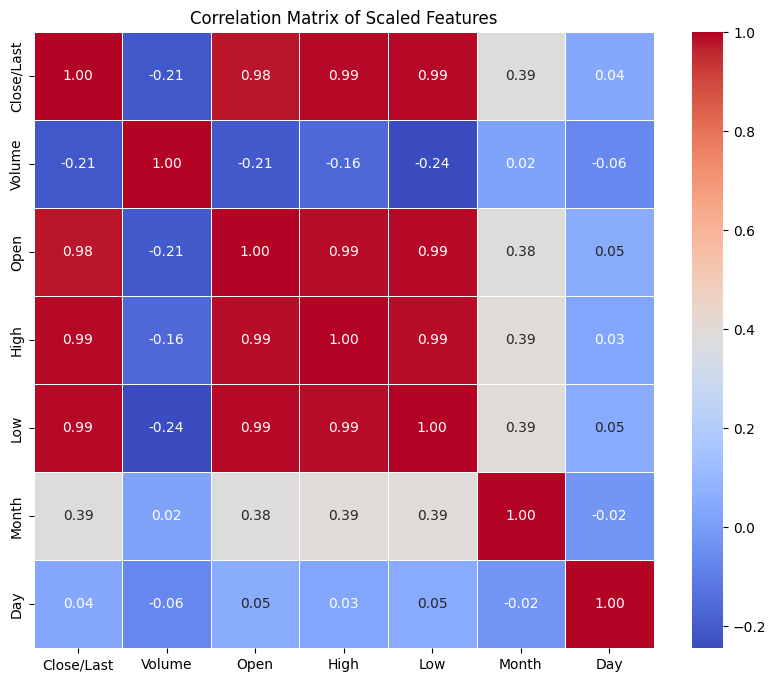

In [ ]:
correlation_matrix = dataset_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Scaled Features')
plt.show()

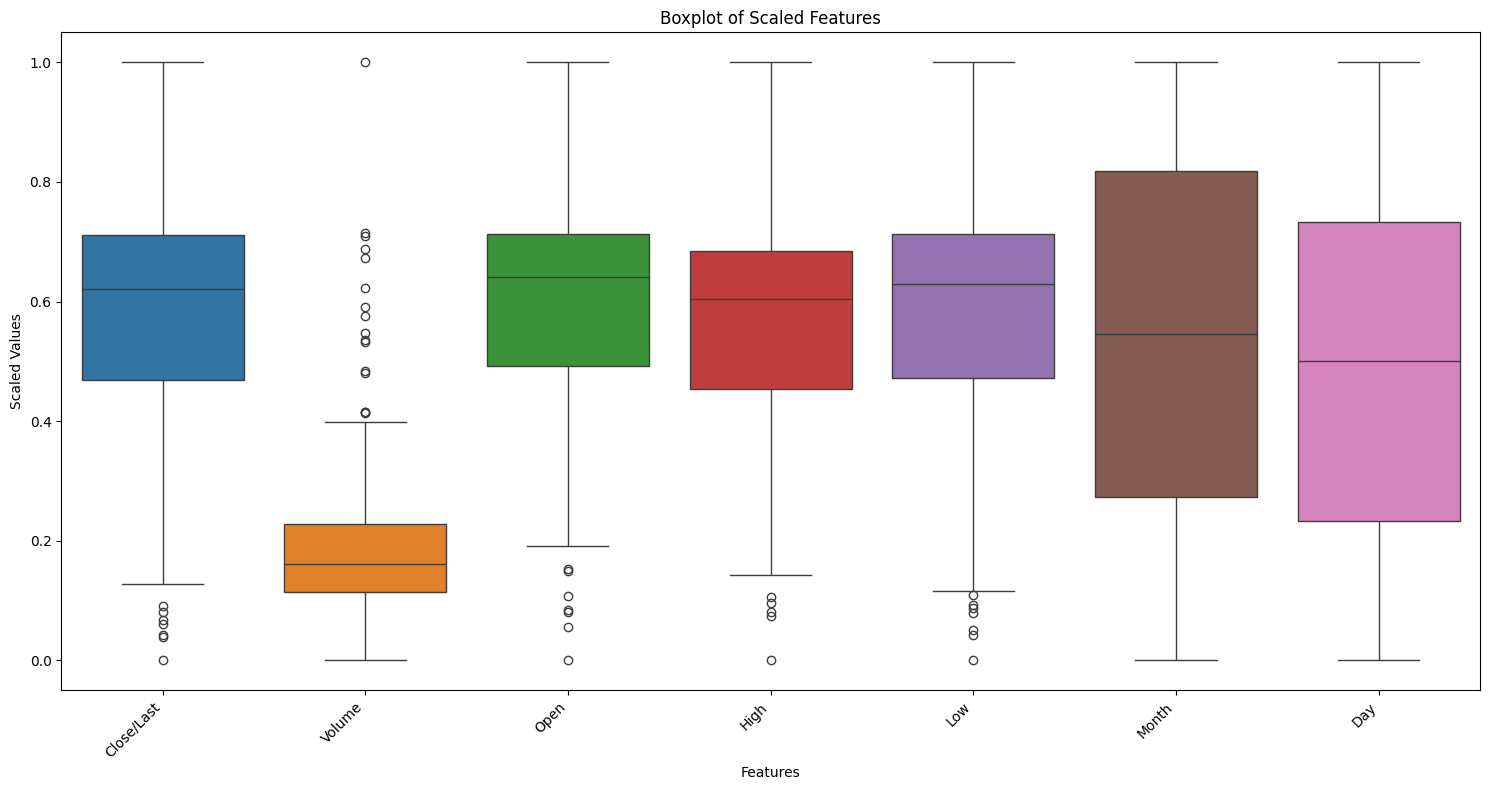

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=dataset_scaled)
plt.title('Boxplot of Scaled Features')
plt.xlabel('Features')
plt.ylabel('Scaled Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
## Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    Dense(y_train.shape[1])
])

# Compilation
model_bilstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

# Early stopping
early_stopping_bilstm = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training
history_bilstm = model_bilstm.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.25, callbacks=[early_stopping_bilstm])

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - RootMeanSquaredError: 0.2631 - loss: 0.0709 - val_RootMeanSquaredError: 0.1707 - val_loss: 0.0291
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - RootMeanSquaredError: 0.1920 - loss: 0.0369 - val_RootMeanSquaredError: 0.1639 - val_loss: 0.0269
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - RootMeanSquaredError: 0.1987 - loss: 0.0399 - val_RootMeanSquaredError: 0.1583 - val_loss: 0.0251
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - RootMeanSquaredError: 0.1799 - loss: 0.0324 - val_RootMeanSquaredError: 0.1527 - val_loss: 0.0233
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - RootMeanSquaredError: 0.1752 - loss: 0.0308 - val_RootMeanSquaredError: 0.1285 - val_loss: 0.0165
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - RootMeanSquaredError: 0.1560 - loss: 0.0244 - val_RootMeanSquaredError: 0.1268 - val_loss: 0.0161
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - RootMeanSquaredError: 0.1521 - loss: 0.0234 -

In [ ]:
# Evaluate LSTM model
lstm_evaluation = model.evaluate(x_test, y_test, verbose=0)
lstm_rmse = lstm_evaluation[1]  # Assuming RootMeanSquaredError is the second metric
print(f"LSTM Model RMSE: {lstm_rmse:.4f}")

# Evaluate Bidirectional LSTM model
bilstm_evaluation = model_bilstm.evaluate(x_test, y_test, verbose=0)
bilstm_rmse = bilstm_evaluation[1]  # Assuming RootMeanSquaredError is the second metric
print(f"Bidirectional LSTM Model RMSE: {bilstm_rmse:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# RMSE values
models = ['LSTM', 'Bidirectional LSTM']
rmse_values = [0.1119, 0.1058]

# Create bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(models, rmse_values, color=['skyblue', 'orange'])
plt.title('RMSE Comparison: LSTM vs Bidirectional LSTM')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values)+0.02)

# Annotate bars with RMSE values
for bar, rmse in zip(bars, rmse_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{rmse}', ha='center', va='bottom', fontsize=12)

plt.show()


In [ ]:
pip install keras-tuner

**Reasoning**:
Now that `keras-tuner` is installed, I will import `HyperModel` and `RandomSearch` to enable hyperparameter tuning functionality.



In [ ]:
from keras_tuner.src.engine import hypermodel as HyperModel
from keras_tuner.src.tuners import randomsearch as RandomSearch
print("Keras Tuner modules imported successfully.")

**Reasoning**:
I will define a `build_model_linear` function to create a tunable linear regression model. This function will allow `keras_tuner` to search for optimal hyperparameters such as the number of dense units and dropout rate.



In [ ]:
def build_model_linear(hp):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'),
        keras.layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])
    return model

print("Linear regression model builder function defined.")

**Reasoning**:
I will define a `build_model_lstm` function to create a tunable LSTM model. This function will allow `keras_tuner` to search for optimal hyperparameters such as the number of LSTM units and dropout rates for each LSTM layer.



In [ ]:
def build_model_lstm(hp):
    model = keras.Sequential([
        keras.layers.LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32), input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
        keras.layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32), return_sequences=True),
        keras.layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.LSTM(units=hp.Int('lstm_units_3', min_value=32, max_value=128, step=32), return_sequences=False),
        keras.layers.Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.Dense(y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])
    return model

print("LSTM model builder function defined.")

In [ ]:
def build_model_bilstm(hp):
    model = keras.Sequential([
        keras.layers.Bidirectional(keras.layers.LSTM(units=hp.Int('bilstm_units_1', min_value=32, max_value=128, step=32), return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Dropout(hp.Float('bilstm_dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.Bidirectional(keras.layers.LSTM(units=hp.Int('bilstm_units_2', min_value=32, max_value=128, step=32), return_sequences=True)),
        keras.layers.Dropout(hp.Float('bilstm_dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.Bidirectional(keras.layers.LSTM(units=hp.Int('bilstm_units_3', min_value=32, max_value=128, step=32), return_sequences=False)),
        keras.layers.Dropout(hp.Float('bilstm_dropout_3', min_value=0.1, max_value=0.5, step=0.1)),
        keras.layers.Dense(y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])
    return model

print("Bidirectional LSTM model builder function defined.")

**Reasoning**:
Now that the model building functions are defined, I will initialize and run the `RandomSearch` tuner for the Linear Regression model. This will begin the hyperparameter optimization process to find the best configuration for the linear model.



In [ ]:
tuner_linear = RandomSearch(
    build_model_linear,
    objective='val_RootMeanSquaredError',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='linear_model_tuning'
)

print("Searching for best hyperparameters for Linear Regression model...")
tuner_linear.search(x_train, y_train, epochs=50, validation_split=0.25, callbacks=[early_stopping_linear])

print("Linear Regression Hyperparameter Search Complete.")

best_hps_linear = tuner_linear.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal units for Linear Regression: {best_hps_linear.get('units')}")
print(f"Optimal dropout for Linear Regression: {best_hps_linear.get('dropout')}")

model_linear_tuned = tuner_linear.get_best_models(num_models=1)[0]
linear_tuned_evaluation = model_linear_tuned.evaluate(x_test, y_test, verbose=0)
linear_tuned_rmse = linear_tuned_evaluation[1]
print(f"Tuned Linear Regression Model RMSE: {linear_tuned_rmse:.4f}")

**Reasoning**:
The `TypeError: 'module' object is not callable` in the previous step indicates that `RandomSearch` was imported as a module rather than as a class. I need to correct the import statement to specifically import the `RandomSearch` class from `keras_tuner`.



In [ ]:
from keras_tuner import HyperModel, RandomSearch
print("Keras Tuner modules imported successfully.")

**Reasoning**:
Since the `RandomSearch` class is now correctly imported, I will re-attempt to initialize and run the `RandomSearch` tuner for the Linear Regression model. This will proceed with the hyperparameter optimization process as intended.



In [ ]:
tuner_linear = RandomSearch(
    build_model_linear,
    objective='val_RootMeanSquaredError',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='linear_model_tuning'
)

print("Searching for best hyperparameters for Linear Regression model...")
tuner_linear.search(x_train, y_train, epochs=50, validation_split=0.25, callbacks=[early_stopping_linear])

print("Linear Regression Hyperparameter Search Complete.")

best_hps_linear = tuner_linear.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal units for Linear Regression: {best_hps_linear.get('units')}")
print(f"Optimal dropout for Linear Regression: {best_hps_linear.get('dropout')}")

model_linear_tuned = tuner_linear.get_best_models(num_models=1)[0]
linear_tuned_evaluation = model_linear_tuned.evaluate(x_test, y_test, verbose=0)
linear_tuned_rmse = linear_tuned_evaluation[1]
print(f"Tuned Linear Regression Model RMSE: {linear_tuned_rmse:.4f}")

# Task
Initialize and run a hyperparameter tuner for the LSTM model, then for the Bidirectional LSTM model, and finally report the best hyperparameters and performance (RMSE) for each tuned model.

## Define Tunable LSTM Model

### Subtask:
Create a function that builds an LSTM model with tunable hyperparameters, including number of LSTM layers, units, and dropout.


The `build_model_lstm` function has already been defined, satisfying the requirements for building a tunable LSTM model.

## Perform Tuning for LSTM Model

### Subtask:
Instantiate and run a hyperparameter tuner for the LSTM model.


**Reasoning**:
I will initialize and run the `RandomSearch` tuner for the LSTM model. This will begin the hyperparameter optimization process to find the best configuration for the LSTM model, and then I will print the optimal hyperparameters and the RMSE of the tuned model.



In [ ]:
tuner_lstm = RandomSearch(
    build_model_lstm,
    objective='val_RootMeanSquaredError',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lstm_model_tuning'
)

print("Searching for best hyperparameters for LSTM model...")
tuner_lstm.search(x_train, y_train, epochs=50, validation_split=0.25, callbacks=[early_stopping])

print("LSTM Hyperparameter Search Complete.")

best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal lstm_units_1 for LSTM: {best_hps_lstm.get('lstm_units_1')}")
print(f"Optimal lstm_units_2 for LSTM: {best_hps_lstm.get('lstm_units_2')}")
print(f"Optimal lstm_units_3 for LSTM: {best_hps_lstm.get('lstm_units_3')}")
print(f"Optimal dropout_1 for LSTM: {best_hps_lstm.get('dropout_1')}")
print(f"Optimal dropout_2 for LSTM: {best_hps_lstm.get('dropout_2')}")
print(f"Optimal dropout_3 for LSTM: {best_hps_lstm.get('dropout_3')}")

model_lstm_tuned = tuner_lstm.get_best_models(num_models=1)[0]
lstm_tuned_evaluation = model_lstm_tuned.evaluate(x_test, y_test, verbose=0)
lstm_tuned_rmse = lstm_tuned_evaluation[1]
print(f"Tuned LSTM Model RMSE: {lstm_tuned_rmse:.4f}")